In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

def calculate_wcss(data, labels, centers):
    wcss = 0
    for i in range(max(labels) + 1):
        cluster_points = data[labels == i]
        center = centers[i]
        wcss += np.sum((cluster_points - center) ** 2)
    return wcss

def evaluate_kmeans(df_latents_scaled, cluster_range, random_state=1):
    silhouette_avg_list = []
    davies_bouldin_list = []
    wcss_list = []
    gap_list = []

    for k in cluster_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state, init='k-means++', batch_size=8, max_iter=100)
        kmeans_labels = kmeans.fit_predict(df_latents_scaled)
        centers = kmeans.cluster_centers_

        silhouette_avg = silhouette_score(df_latents_scaled, kmeans_labels)
        silhouette_avg_list.append(silhouette_avg)

        davies_bouldin = davies_bouldin_score(df_latents_scaled, kmeans_labels)
        davies_bouldin_list.append(davies_bouldin)

        wcss = calculate_wcss(df_latents_scaled, kmeans_labels, centers)
        wcss_list.append(wcss)

    return silhouette_avg_list, davies_bouldin_list, wcss_list

# Load your data into df_latents
latents = pd.read_csv('latents.csv', index_col=[0])
clinical = pd.read_csv('clinicals.csv', index_col=[0])
rolled_data = np.load('rolled_data.npy')

# Standardize the data
scaler = StandardScaler()
df_latents_scaled = scaler.fit_transform(latents)

# Define the range of clusters
cluster_range = range(2, 9)
silhouette_avg_lists = []
davies_bouldin_lists = []
wcss_lists = []

for i in range(1, 25):
    # Evaluate KMeans for different cluster numbers
    silhouette_avg_list, davies_bouldin_list, wcss_list = evaluate_kmeans(df_latents_scaled, cluster_range, random_state=i)
    davies_bouldin_lists.append(davies_bouldin_list)
    silhouette_avg_lists.append(silhouette_avg_list)
    wcss_lists.append(wcss_list)

median_silhouette = np.mean(silhouette_avg_lists, axis=0)
median_davies = np.mean(davies_bouldin_lists, axis=0)
median_wcss = np.mean(wcss_lists, axis=0)

# Calculate Gap Statistic
gap_statistic = np.log(median_wcss) - np.log(wcss_lists)
median_gap = np.mean(gap_statistic.tolist(), axis=0)

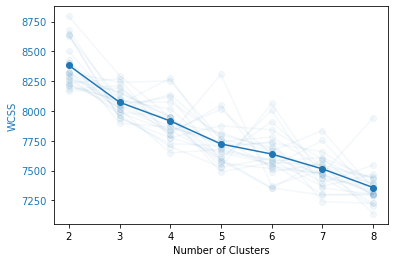

In [15]:
# Create subplots for silhouette scores
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color='tab:blue')
ax1.set_title('')

for i in range(1, 24):
    ax1.plot(cluster_range, wcss_lists[i - 1], marker='o', color='tab:blue', alpha=0.05, linestyle='-',
             label=f'Silhouette Score ({i})')

ax1.plot(cluster_range, median_wcss, marker='o', color='tab:blue', linestyle='-', label='Median Silhouette Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')


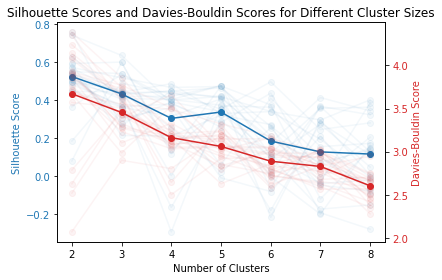

In [30]:
# Create subplots for silhouette scores
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='tab:blue')
ax1.set_title('Silhouette Scores and Davies-Bouldin Scores for Different Cluster Sizes')

for i in range(1, 24):
    ax1.plot(cluster_range, [x * 10 for x in silhouette_avg_lists[i - 1]], marker='o', color='tab:blue', alpha=0.05, linestyle='-',
             label=f'Silhouette Score ({i})')

ax1.plot(cluster_range, median_silhouette* 10 , marker='o', color='tab:blue', linestyle='-', label='Median Silhouette Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')
#ax1.legend(loc='upper left')

# Create subplots for Davies-Bouldin scores
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Davies-Bouldin Score', color='tab:red')

for i in range(1, 24):
    ax2.plot(cluster_range, davies_bouldin_lists[i - 1], marker='o', color='tab:red', alpha=0.05, linestyle='-',
             label=f'Davies-Bouldin Score ({i})')

ax2.plot(cluster_range, median_davies, marker='o', color='tab:red', linestyle='-', label='Median Davies-Bouldin Score')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()  # ensure the right y-label is not slightly clipped
plt.show()

C:\Users\mzkolk\AppData\Local\Temp\ipykernel_13388\2113845450.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], cmap='jet')


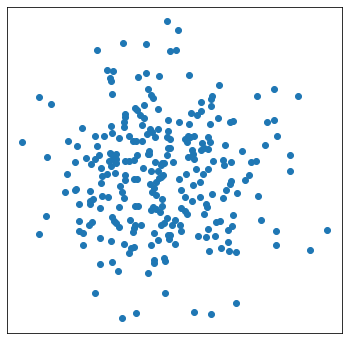

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2, perplexity=5, learning_rate=0.0001)
X_tsne = tsne.fit_transform(df_latents_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
#df_tsne['cluster'] = latents['cluster']

plt.figure(figsize=(6, 6))
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], cmap='jet')
plt.xticks([])  # Removes x-axis tick labels
plt.yticks([])  # Removes y-axis tick labels

plt.show()


In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose the number of clusters (k)
k = 5

scaler = StandardScaler()
df_latents_scaled = scaler.fit_transform(latents)

# Apply Agglomerative Clustering
cluster_train = MiniBatchKMeans(n_clusters=k, random_state=1, init='k-means++', max_iter=500)
latents['cluster'] = cluster_train.fit_predict(df_latents_scaled)
